In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

/tmp/ipykernel_496321/2400937917.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [4]:
# Generate some fake data for demonstration
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

n = 100
p = 5

X = np.random.randn(n, p)
beta = np.random.randn(p, 1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs = sigmoid(X @ beta + 1)
y = np.random.binomial(1, probs)

# Logistic Regression as ANN

The binary logistic regression model is defined as:

$$
\begin{align*}
y_i & \sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) & = \beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}
\end{align*}
$$


In [8]:
logreg = LogisticRegression(penalty=None, fit_intercept=True)
logreg.fit(X, y.squeeze())
print(logreg.coef_)

[[-0.33889227  0.79063966 -0.08362045  1.25691865  0.22499831]]


In [9]:
beta.T

array([[-0.27165423,  0.8024873 , -0.19713689,  1.63804069,  0.19930395]])

## Logistic Regression as a ANN

As the linear regression model, the logistic regression model can be seen as a single-layer artificial neural network. The model is defined as:

$$
\hat{y}_i = \sigma(b + w_1 x_{i1} + \ldots + w_p x_{ip}) = \sigma(b + w^T x_i)
$$

The predictions are again made using the dot product of the input features and the weights, plus a bias term. The difference is that the output is passed through the sigmoid function, which maps the output to the interval $[0, 1]$. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


## Logistic Regression as a ANN

As the linear regression model, the logistic regression model can be seen as a single-layer artificial neural network. The model is defined as:

$$
\hat{y}_i = \sigma(b + w_1 x_{i1} + \ldots + w_p x_{ip}) = \sigma(b + w^T x_i)
$$

The predictions are again made using the dot product of the input features and the weights, plus a bias term. The difference is that the output is passed through the sigmoid function, which maps the output to the interval $[0, 1]$. The sigmoid function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


```{mermaid}
%%| label: fig-single-neuron
%%| fig-width: 6
%%| fig-cap: "ANN model for linear regression for a single observation"

graph LR
    x1["$$x_{i1}$$"] -->|$$w_1$$| B(($$w^T x_i + b$$))
    x2["$$x_{i2}$$"] -->|$$w_2$$| B
    xp["$$x_{ip}$$"] -->|$$w_p$$| B
    B --> |"$$\sigma$$"|C["$$\hat{y}$$"]
```

The loss function for logistic regression is the binary cross-entropy:

$$
L_i = -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i)
$$

Its derivative with respect to the weights is:

$$
\frac{\partial L_i}{\partial w_j} = (y_i - \hat{y}_i) x_{ij}
$$

and with respect to the bias:

$$
\frac{\partial L_i}{\partial b} = (y_i - \hat{y}_i)
$$

Using these gradients, we can derive the update rules for the weights and the bias:

$$
w^{t + 1}_j = w^{t}_j + \eta \sum_i (y_i - \hat{y}_i) x_{ij}
$$

$$
b^{t + 1} = b^{t} + \eta \sum_i (y_i - \hat{y}_i)
$$

where $\eta$ is the learning rate.



/tmp/ipykernel_496321/2164143203.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  losses[epoch] = epoch_loss / n


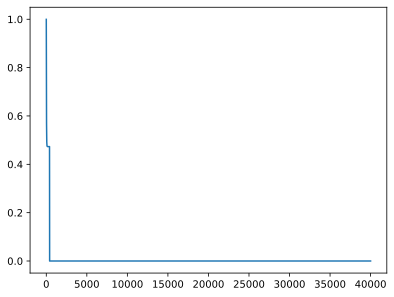

In [5]:
epochsn = 400
lr = 0.002

w = np.random.randn(p)
b = np.random.randn(1)

losses = np.zeros(epochsn * n)

for epoch in range(epochsn):
    epoch_loss = 0
    for i in range(n):
        y_pred = sigmoid(w.dot(X[i]) + b)
        
        loss = -y[i] * np.log(y_pred) - (1 - y[i]) * np.log(1 - y_pred)
        epoch_loss += loss

        w_grad = (y_pred - y[i]) * X[i]
        b_grad = y_pred - y[i]

        w -= lr * w_grad
        b -= lr * b_grad
        
    losses[epoch] = epoch_loss / n

plt.plot(losses)

In [6]:
w

array([-0.34293754,  0.78731734, -0.08288629,  1.26070417,  0.22400853])

In [7]:
logreg.coef_

NameError: name 'logreg' is not defined